## Analiza Medicinskih slik: laboratorijske vaje
Predno oddate vašo rešitev jo najprej ustrezno preverite. Najprej **resetirajte Python jedro** (v meniju izberite Kernel$\rightarrow$Restart) in potem **zaženite vse celice** (v meniju izberite Cell$\rightarrow$Run All).

Preverite ali ste nadomestili z vašo kodo oz. besedilom bloke, ki so označeni kot `YOUR CODE HERE` oz. "YOUR ANSWER HERE", kot tudi navedli vaše IME in SODELAVCE spodaj:

In [ ]:
IME = ""
SODELAVCI = ""

---

# Analiza slik z nevronskimi mrežami

## 3. Razgradnja slik z nevronskimi mrežami

### Motivacija

Razgradnjo MRI slik pri bolnikih z multiplo sklerozo je klinično motivirana. Preko razgradnje lahko izvajamo meritve razgrajenih struktur, kot so prostornina bele in sive možganovine, prostorina in število patoloških lezij, ipd. Te meritve, npr. prostornina zdravih možganskih struktur in patoloških lezij odražata stanje bolezni, pri čemer na prvo vpliva pospešena nevrodegeneracija pri pospešenem poteku bolezni, druga pa je odraz akutne vnetne aktivnosti bolezni. Fenotipi multiple skleroze se razlikujejo glede na te dva parametra, zato so meritve prostornine, pa tudi drugih parametrov teh struktur pomembni biomarkerji za napovedovanje poteka bolezni in odziva na zdravljenje.

### Postopek razgradnje

Dano zbirko MR slik preiskave glave bomo razgradili z uporabo nevronskih mrež. Uporabili bomo trenutno najbolj uveljavljeno arhitekturo mreže [U-Net](https://arxiv.org/abs/1505.04597), ki se uporablja za razgradnjo slik.

Izvedli bomo binarno razgradnjo MR slik glave, in sicer za različne strukture:
- **CSF=1**: likvorska tekočina
- **GM=2**: siva možganovina
- **CSF=3**: bela možganovina
- **LESIONS=10**: patološke lezije

Delovanje bomo preizkusili tudi na kombinacijah teh struktur, prav tako nas bo zanimalo katera modaliteta največ prispeva k kakovosti razgradnje. Pri tem bomo kot predznanje uporabili le dane referenčne razgradnje teh slik. 

### Uvažanje knjižnic

In [78]:
import os
import sys
import random
import warnings

import numpy as np
import SimpleITK as itk
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

import tensorflow as tf

from os.path import join
from amslib import load_mri_brain_data
from amslib import load_mri_brain_data_3slices

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)

seed = 42
random.seed = seed
np.random.seed = seed

### Konstante in parametri

In [79]:
MODEL_NAME = 'model-t1-nove-maske'
# nastavi željeno velikost slik
IMG_WIDTH = 128
IMG_HEIGHT = 128
MODALITIES = ('t1')
IMG_CHANNELS = 3
# določi delež testnih podatkov
TEST_DATA_FRACTION = 0.1

## 3.1 Naloži MRI podatke in loči med učne in testne

Za nalaganje podatkov bomo uporabili funkcijo **load_mri_brain_data()**, ki smo jo predstavili v prvem delu vaje in ki je dana v knjižnici **amslib**. Nato bomo z uporabo funkcije **train_test_split()** ustvarili učno in testno zbirki podatkov. Funkcija naključno priredi posamezno sliko in pripadajoče učne oznake v testno množico v predvidenem deležu, ki je podan s parametrom **test_size**. Slednji je v našem primeru določen s konstanto **TEST_DATA_FRACTION**. Učne podatke bomo uporabili za učenje modela, testne pa za preverjanje kakovosti rešitve oz. zmožnosti posploševanja naučenega modela.

In [80]:
X, Y_seg = load_mri_brain_data_3slices(output_size=(IMG_WIDTH, IMG_HEIGHT), modalities=('stir'),data_location='./data_t1_nove_maske_vse')
Y_seg = (Y_seg > 0.99).astype('int8')
#Y_seg = Y_seg.astype('int8')
X_train, X_test, y_train, y_test = train_test_split(X, Y_seg , test_size=TEST_DATA_FRACTION)

print('Velikost 4D polja za učenje: {}'.format(X_train.shape))
print('Velikost 4D polja za testiranje: {}'.format(X_test.shape))


100%|██████████| 10/10 [00:11<00:00,  1.10s/it]


Velikost 4D polja za učenje: (933, 128, 128, 3)
Velikost 4D polja za testiranje: (104, 128, 128, 3)


### Izris vzorca učnih podatkov

Text(0.5, 1.0, 'Referenčna razgradnja')

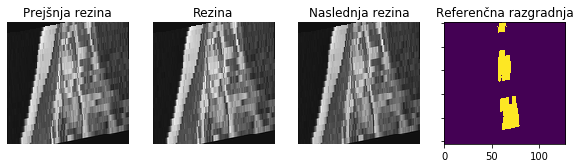

In [81]:
# Check if training data looks all right
ix = random.randint(0, X_train.shape[0]-1)
_, _, num_modalities = X_train[ix].shape

titles = ['Prejšnja rezina']+['Rezina']+['Naslednja rezina'] + ['Referenčna razgradnja']
f, ax = plt.subplots(1, num_modalities+1, sharex=True, sharey=True, figsize=(10, 5))
for i in range(num_modalities):
    ax[i].imshow(X_train[ix][:,:,i], cmap='gray')
    ax[i].set_title(titles[i])
    ax[i].axis('off')
ax[-1].imshow(np.squeeze(y_train[ix]))
ax[-1].set_title(titles[-1])

## 3.2 Načrtovanje in učenje U-net modela

V naslednjem bloku bomo načrtali U-Net model, ki temelji na [U-Net: Convolutional Networks for Biomedical Image Segmentation](https://arxiv.org/pdf/1505.04597.pdf) in je podoben [javno dostopni implementaciji](https://github.com/jocicmarko/ultrasound-nerve-segmentation) iz tekmovanja Kaggle Ultrasound Nerve Segmentation.

![](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png)

### Definicija modela

Uporabili bomo **Functional (model API)** način definicije modela v knjižnici **Keras**. Določili bomo objekte posameznih gradnikov in jih poljubno (tj. ne nujno zaporedoma) povezali med seboj. Na koncu moramo dobiti dva objekta, kjer prvi predstavlja vhod, drugi pa izhod. S tema objektoma nato inicializiramo model s klicem konstruktorja **Model(inputs=, outputs=)**.

Uporabljalli bomo že znane osnovne gradnike **Conv2D**, **MaxPooling2D**, **Dropout**, **Dense** in **Flatten**, poleg tega pa še:
- **Conv2DTranspose**: konvolucijska plast, ki poviša velikost izhodnega polja glede na vhodno; gradniku podamo število filtrov, velikost filtrov, prostorski korak filtra (*stride*)

Pri konvolucijskih plasteh **Conv2D** in **Conv2DTranspose** smo nastavili še parametra inicializacije uteži po postopku *he_normal* in dodajanje elementov *padding* za zagotavljanje ustrezne velikosti izhodnega polja. S klicem funkcije **summary()** dobimo izpis strukture in števila parametrov modela.

In [82]:
# vhodna plast
inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))

# V vzorec levi del navzdol
    #1 layer
S = Lambda(lambda x:x)(inputs)
C1 = Conv2D(16,(3,3),activation = 'elu',kernel_initializer='he_normal',padding='same')(S) #definiramo plast pod spremenljivko C1
C1 = Dropout(0.1)(C1) #
C1 = Conv2D(16,(3,3),activation = 'elu',kernel_initializer='he_normal',padding='same')(C1) #(C1) - vhod
P1 = MaxPooling2D((2,2))(C1)
    
    #2 layer
C2 = Conv2D(32,(3,3),activation = 'elu',kernel_initializer='he_normal',padding='same')(P1)
C2 = Dropout(0.1)(C2)
C2 = Conv2D(32,(3,3),activation = 'elu',kernel_initializer='he_normal',padding='same')(C2)
P2 = MaxPooling2D((2,2))(C2)

    #3 layer
C3 = Conv2D(64,(3,3),activation = 'elu',kernel_initializer='he_normal',padding='same')(P2)
C3 = Dropout(0.2)(C3)
C3 = Conv2D(64,(3,3),activation = 'elu',kernel_initializer='he_normal',padding='same')(C3)
P3 = MaxPooling2D((2,2))(C3)

    #4 layer
C4 = Conv2D(128,(3,3),activation = 'elu',kernel_initializer='he_normal',padding='same')(P3)
C4 = Dropout(0.2)(C4)
C4 = Conv2D(128,(3,3),activation = 'elu',kernel_initializer='he_normal',padding='same')(C4)
P4 = MaxPooling2D((2,2))(C4)

    #5 layer
C5 = Conv2D(256,(3,3),activation = 'elu',kernel_initializer='he_normal',padding='same')(P4)
C5 = Dropout(0.3)(C5)
C5 = Conv2D(256,(3,3),activation = 'elu',kernel_initializer='he_normal',padding='same')(C5)
P5 = MaxPooling2D((2,2))(C5)

# V vzorez desni del navzgor
    #u - up sampling
    #1 layer
U6 = Conv2DTranspose(128, (2,2),strides =(2,2),padding='same')(C5)
U6 = concatenate([U6,C4])
C6 = Conv2D(128, (3,3), activation = 'elu',kernel_initializer='he_normal',padding='same')(U6)
C6 = Dropout(0.2)(C6)
C6 = Conv2D(128, (3,3), activation = 'elu',kernel_initializer='he_normal',padding='same')(C6)

    #2 layer
U7 = Conv2DTranspose(64, (2,2),strides =(2,2),padding='same')(C6)
U7 = concatenate([U7,C3])
C7 = Conv2D(64, (3,3), activation = 'elu',kernel_initializer='he_normal',padding='same')(U7)
C7 = Dropout(0.2)(C7)
C7 = Conv2D(64, (3,3), activation = 'elu',kernel_initializer='he_normal',padding='same')(C7)

    #3 layer
U8 = Conv2DTranspose(32, (2,2),strides =(2,2),padding='same')(C7)
U8 = concatenate([U8,C2])
C8 = Conv2D(32, (3,3), activation = 'elu',kernel_initializer='he_normal',padding='same')(U8)
C8 = Dropout(0.1)(C8)
C8 = Conv2D(32, (3,3), activation = 'elu',kernel_initializer='he_normal',padding='same')(C8)

    #4 layer
U9 = Conv2DTranspose(16, (2,2),strides =(2,2),padding='same')(C8)
U9 = concatenate([U9,C1])
C9 = Conv2D(16, (3,3), activation = 'elu',kernel_initializer='he_normal',padding='same')(U9)
C9 = Dropout(0.1)(C9)
C9 = Conv2D(16, (3,3), activation = 'elu',kernel_initializer='he_normal',padding='same')(C9)

outputs = Conv2D(1,(1,1), activation = 'sigmoid')(C9)

model = Model(inputs=[inputs], outputs=[outputs])
# povzetek modela
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
lambda_5 (Lambda)               (None, 128, 128, 3)  0           input_5[0][0]                    
__________________________________________________________________________________________________
conv2d_77 (Conv2D)              (None, 128, 128, 16) 448         lambda_5[0][0]                   
__________________________________________________________________________________________________
dropout_37 (Dropout)            (None, 128, 128, 16) 0           conv2d_77[0][0]                  
__________________________________________________________________________________________________
conv2d_78 

### Definicija kriterijskih funkcij

Kriterijske funkcije lahko v obliki Python funkcij z ustreznimi vhodnimi parametri:
- **y_true**: referenčna razgradnja ali oznaka
- **y_pred**: z modelom določena razgradnja ali oznaka
    
Poizkusite delovanje različnih funkcij in njihov vpliv na kakovost razgradnje.

In [83]:
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

def iou_coef(y_true, y_pred, smooth=1):
    """
    IoU = (|X &amp; Y|)/ (|X or Y|)
    """
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    union = K.sum(y_true,-1) + K.sum(y_pred,-1) - intersection
    return (intersection + smooth) / ( union + smooth)

def iou_coef_loss(y_true, y_pred):
    return -iou_coef(y_true, y_pred)

def dice_coef(y_true, y_pred):
    """
    DSC = (2*|X &amp; Y|)/ (|X| + |Y|)
    """    
    smooth = 1
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

### Nastavitve modela za učenje

Funkcija **compile()** opravi prevajanje modela v strojno kodo, ki je primerna za učinkovito izvajanje. Nekateri pomembni parametri funkcije so:
- **optimizer**: naziv ali objekt postopka optimizacije (glej možnosti [optimizers](https://keras.io/optimizers/))
- **loss**: naziv ali objekt kriterijske funkcije (glej možnosti [losses](https://keras.io/losses/))
- **metrics**: seznam metrik za vrednotenje modela med učenjem in testiranjem

Pomemben hiperparameter vsakega postopka optimizacije je tudi učna konstanta. V tem primeru bomo prepustili postopku optimizacije, da uporabi privzeto vrednost.

In [84]:
model.compile(
    optimizer='adam', 
    loss='binary_crossentropy', 
    metrics=[dice_coef])

### Hiperparametri

Nekaj pomembnih izpostavljenih parametrov, ki so vezani na učenje modela.

In [85]:
BATCH_SIZE = 5
NUM_EPOCHS = 200

### Učenje modela

In [86]:
# zaženi učenje modela
earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint(join('models', MODEL_NAME), verbose=1, save_best_only=True)
results = model.fit(X_train, y_train, validation_split=0.1, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, 
                    callbacks=[earlystopper, checkpointer])

Train on 839 samples, validate on 94 samples
Epoch 1/200
839/839 [==============================] - 7s 8ms/step - loss: 0.1449 - dice_coef: 0.4047 - val_loss: 0.0942 - val_dice_coef: 0.6299

Epoch 00001: val_loss improved from inf to 0.09415, saving model to models/model-t1-nove-maske
Epoch 2/200
839/839 [==============================] - 3s 3ms/step - loss: 0.0675 - dice_coef: 0.6957 - val_loss: 0.0660 - val_dice_coef: 0.7723

Epoch 00002: val_loss improved from 0.09415 to 0.06600, saving model to models/model-t1-nove-maske
Epoch 3/200
839/839 [==============================] - 3s 3ms/step - loss: 0.0463 - dice_coef: 0.7929 - val_loss: 0.0470 - val_dice_coef: 0.8382

Epoch 00003: val_loss improved from 0.06600 to 0.04701, saving model to models/model-t1-nove-maske
Epoch 4/200
839/839 [==============================] - 2s 3ms/step - loss: 0.0398 - dice_coef: 0.8249 - val_loss: 0.0338 - val_dice_coef: 0.8625

Epoch 00004: val_loss improved from 0.04701 to 0.03378, saving model to models

## 3.3 Vrednotenje razgradnje

Kakovost razgradnje bomo vrednotili **kvalitativno** s prikazom in primerjavo pridobljene in referenčne razgradnje ter **kvantitativno** z izračunom Diceovega podobnostnega koeficienta.

### Naloži model in izračunaj razgradnje na učni in testni zbirki

Razgradnja, ki jo bo U-net model vrnil v izhodnem polju *ni binarna*, kot pričakujemo, ampak so dane zvezne vrednosti v razponu [0, 1], ki predstavljajo posteriorno verjetnost oznak. V našem primeru so oznake:
- **0**: ozadje
- **1**: struktura zanimanja, kot smo jo določili z referenčnimi razgradnjami pri učenju

In [87]:
# naloži model
model = load_model(join('models', MODEL_NAME), 
                   custom_objects={'dice_coef': dice_coef, 'dice_coef_loss': dice_coef_loss})

# opravi razgradnjo na učni in testni zbirki
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_test = model.predict(X_test, verbose=1)

print(preds_test.max())
# dobljene vrednosti 
preds_train_t = (preds_train > 0.5).astype(np.uint8)

preds_test_t = ((preds_test > 0.5)&(preds_test < 1.5) ).astype(np.uint8)

104/104 [==============================] - 0s 435us/step
1.0


### Kvalitativno: kakovost razgradnje na učnih vzorcih (ali sploh deluje?)

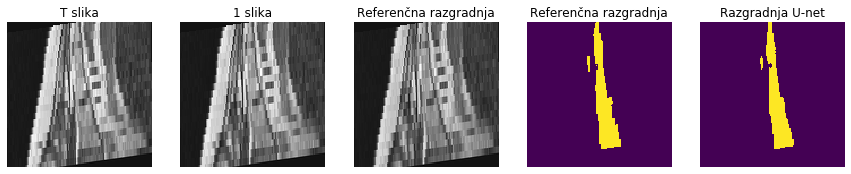

In [88]:
# preveri kakovost razgradnje na učnih vzorcih (sanity check)
ix = random.randint(0, len(preds_train_t)-1)
_, _, num_modalities = X_train[ix].shape

titles = [m.upper() + ' slika' for m in MODALITIES] + ['Referenčna razgradnja', 'Razgradnja U-net']
f, ax = plt.subplots(1, num_modalities+2, sharex=True, sharey=True, figsize=(15, 5))
for i in range(num_modalities):
    ax[i].imshow(X_train[ix][:,:,i], cmap='gray')
    ax[i].set_title(titles[i])
    ax[i].axis('off')
# prikaži referenčno razgradnjo
ax[-2].imshow(np.squeeze(y_train[ix]))
ax[-2].set_title(titles[-2])
ax[-2].axis('off')
# prikaži razgradnjo z U-net
ax[-1].imshow(np.squeeze(preds_train_t[ix]))
ax[-1].set_title(titles[-1])
ax[-1].axis('off')

plt.show()

### Kvalitativno: kakovost razgradnje na testnih vzorcih (zmožnost posploševanja)

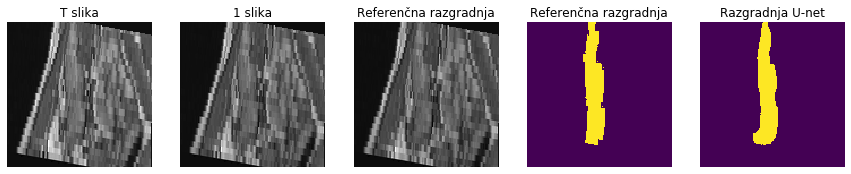

In [89]:
# preveri kakovost razgradnje na naključno izbranih testnih vzorcih
ix = random.randint(0, len(preds_test_t)-1)
_, _, num_modalities = X_test[ix].shape

titles = [m.upper() + ' slika' for m in MODALITIES] + ['Referenčna razgradnja', 'Razgradnja U-net']
f, ax = plt.subplots(1, num_modalities+2, sharex=True, sharey=True, figsize=(15, 5))
for i in range(num_modalities):
    ax[i].imshow(X_test[ix][:,:,i], cmap='gray')
    ax[i].set_title(titles[i])
    ax[i].axis('off')
# prikaži referenčno razgradnjo
ax[-2].imshow(np.squeeze(y_test[ix]))
ax[-2].set_title(titles[-2])
ax[-2].axis('off')
# prikaži razgradnjo z U-net
ax[-1].imshow(np.squeeze(preds_test_t[ix]))
ax[-1].set_title(titles[-1])
ax[-1].axis('off')

plt.show()

### Kvalitativno: povprečna vrednost Diceovega koeficienta na vseh testnih slikah

In [90]:
def dice(result, reference):
    result = np.atleast_1d(result.astype(np.bool))
    reference = np.atleast_1d(reference.astype(np.bool))
    intersection = np.count_nonzero(result & reference)
    size_i1 = np.count_nonzero(result)
    size_i2 = np.count_nonzero(reference)

    try:
        dc = 2. * intersection / float(size_i1 + size_i2)
    except ZeroDivisionError:
        dc = 0.0
    return dc

test_dice = []
for i in range(y_test.shape[0]):
    test_dice.append(dice(preds_test_t[i].flatten(), y_test[i].flatten()))

print('Povprečna vrednost Diceovega koeficienta na testni zbirki: ', np.mean(test_dice))

Povprečna vrednost Diceovega koeficienta na testni zbirki:  0.930642081151302


In [91]:
from amslib import load_mri_brain_data_3slices
X_test2, Y_seg_test2 = load_mri_brain_data_3slices(output_size=(IMG_WIDTH, IMG_HEIGHT), modalities=('stir'), data_location='./data_t1_nove_maske_test')
Y_seg_test2 = (Y_seg_test2 > 0).astype('int8')

print('Velikost 4D polja za učenje: {}'.format(X_test2.shape))
print('Velikost 4D polja za testiranje: {}'.format(X_test2.shape))

model = load_model(join('models', MODEL_NAME), 
                   custom_objects={'dice_coef': dice_coef, 'dice_coef_loss': dice_coef_loss})

preds_test = model.predict(X_test2, verbose=1)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

100%|██████████| 1/1 [00:01<00:00,  1.34s/it]


Velikost 4D polja za učenje: (126, 128, 128, 3)
Velikost 4D polja za testiranje: (126, 128, 128, 3)
126/126 [==============================] - 2s 14ms/step


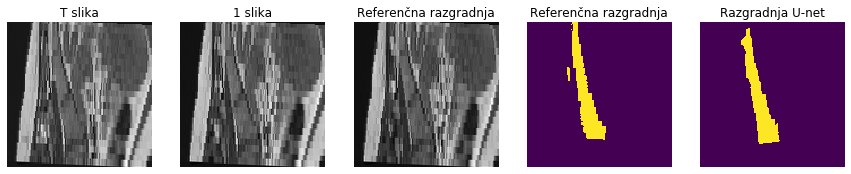

In [92]:
# preveri kakovost razgradnje na naključno izbranih testnih vzorcih
ix = random.randint(0, len(preds_test_t)-1)
_, _, num_modalities = X_test2[ix].shape

titles = [m.upper() + ' slika' for m in MODALITIES] + ['Referenčna razgradnja', 'Razgradnja U-net']
f, ax = plt.subplots(1, num_modalities+2, sharex=True, sharey=True, figsize=(15, 5))
for i in range(num_modalities):
    ax[i].imshow(X_test2[ix][:,:,i], cmap='gray')
    ax[i].set_title(titles[i])
    ax[i].axis('off')
# prikaži referenčno razgradnjo
ax[-2].imshow(np.squeeze(Y_seg_test2[ix]))
ax[-2].set_title(titles[-2])
ax[-2].axis('off')
# prikaži razgradnjo z U-net
ax[-1].imshow(np.squeeze(preds_test_t[ix]))
ax[-1].set_title(titles[-1])
ax[-1].axis('off')

plt.show()

In [93]:
test_dice = []
for i in range(Y_seg_test2.shape[0]):
    test_dice.append(dice(preds_test_t[i].flatten(), Y_seg_test2[i].flatten()))

print('Povprečna vrednost Diceovega koeficienta na testni zbirki: ', np.mean(test_dice))
print('Povprečna vrednost Diceovega koeficienta na testni zbirki: ', np.max(test_dice))
print('Povprečna vrednost Diceovega koeficienta na testni zbirki: ', np.min(test_dice))

Povprečna vrednost Diceovega koeficienta na testni zbirki:  0.8744557566783945
Povprečna vrednost Diceovega koeficienta na testni zbirki:  0.9525111035189614
Povprečna vrednost Diceovega koeficienta na testni zbirki:  0.6582792207792207
